Learn on how to build and optimize model with **gradient boosting.**

#Introduction
By definition, **ensemble methods** combine the predictions of several models (e.g., several trees, in the case of random forest).

Now, we'll learn about another ensemble method called gradient boosting.

#Difference of Decision Tree, Random Forest, and XGBoost

1. Decision Tree:
A decision tree is a simple and interpretable model that recursively splits the data into subsets based on the feature values. It forms a tree-like structure where each internal node represents a test on a feature, each branch represents the outcome of that test, and each leaf node represents the final prediction. The decision tree makes binary decisions at each node to split the data. It is prone to overfitting, especially when the tree becomes deep, capturing noise and leading to poor generalization on unseen data.

2. Random Forest:
Random Forest is an ensemble learning method that builds multiple decision trees and combines their predictions through voting (for classification) or averaging (for regression). Each decision tree is trained on a random subset of the data (bootstrap sample) and a random subset of the features. This randomness reduces overfitting and increases the model's ability to generalize to new data.

3. XGBoost (Extreme Gradient Boosting):
XGBoost is an optimized implementation of the Gradient Boosting algorithm. It creates an ensemble of weak learners (usually shallow decision trees) sequentially, where each new model corrects the errors made by the previous one. XGBoost uses a gradient-based optimization algorithm to minimize a loss function while adding new trees to the ensemble. It also includes regularization terms to control overfitting and speed up the training process. XGBoost is known for its high performance, scalability, and efficiency, making it popular in various machine learning competitions and real-world applications.
**XGBoost** is an implementation of gradient boosting with several additional features focused on perfmance and speed. The final result of an XGBoost model is a weighted sum of the predictions made by all the individual trees in the sequence. The contribution of each tree is adjusted during training based on how well it reduces the overall error.


Note:

* Regularization (penyederhanaan): XGBoost introduces regularization terms to control overfitting during the training process. Regularization helps prevent the model from becoming too complex and ensures better generalization to unseen data.


#Gradient Boosting

**Gradient boosting** is a method that goes through cycles to iteratively add models into an ensemble (setelan).

It begins by initializing the ensemble with a single model, whose predictions can be pretty naive. (Even if its predictions are wildly inaccurate, subsequent (kemudian) additions to the ensemble will address those errors.)

Then, we start the cycle:
1. First, we use the current ensemble to generate predictions for each observation in the dataset. To make a prediction, we **add the predictions from all models** in the ensemble.
2. These predictions are used to calculate a loss function (like mean squared error, for instance).
3. Then, we use the loss function to fit a new model that will be added to the ensemble. Specifically, we determine model parameters so that adding this new model to the ensemble will reduce the loss.
4. Finally, we add the new model to ensemble, and ...
5. Repeat!

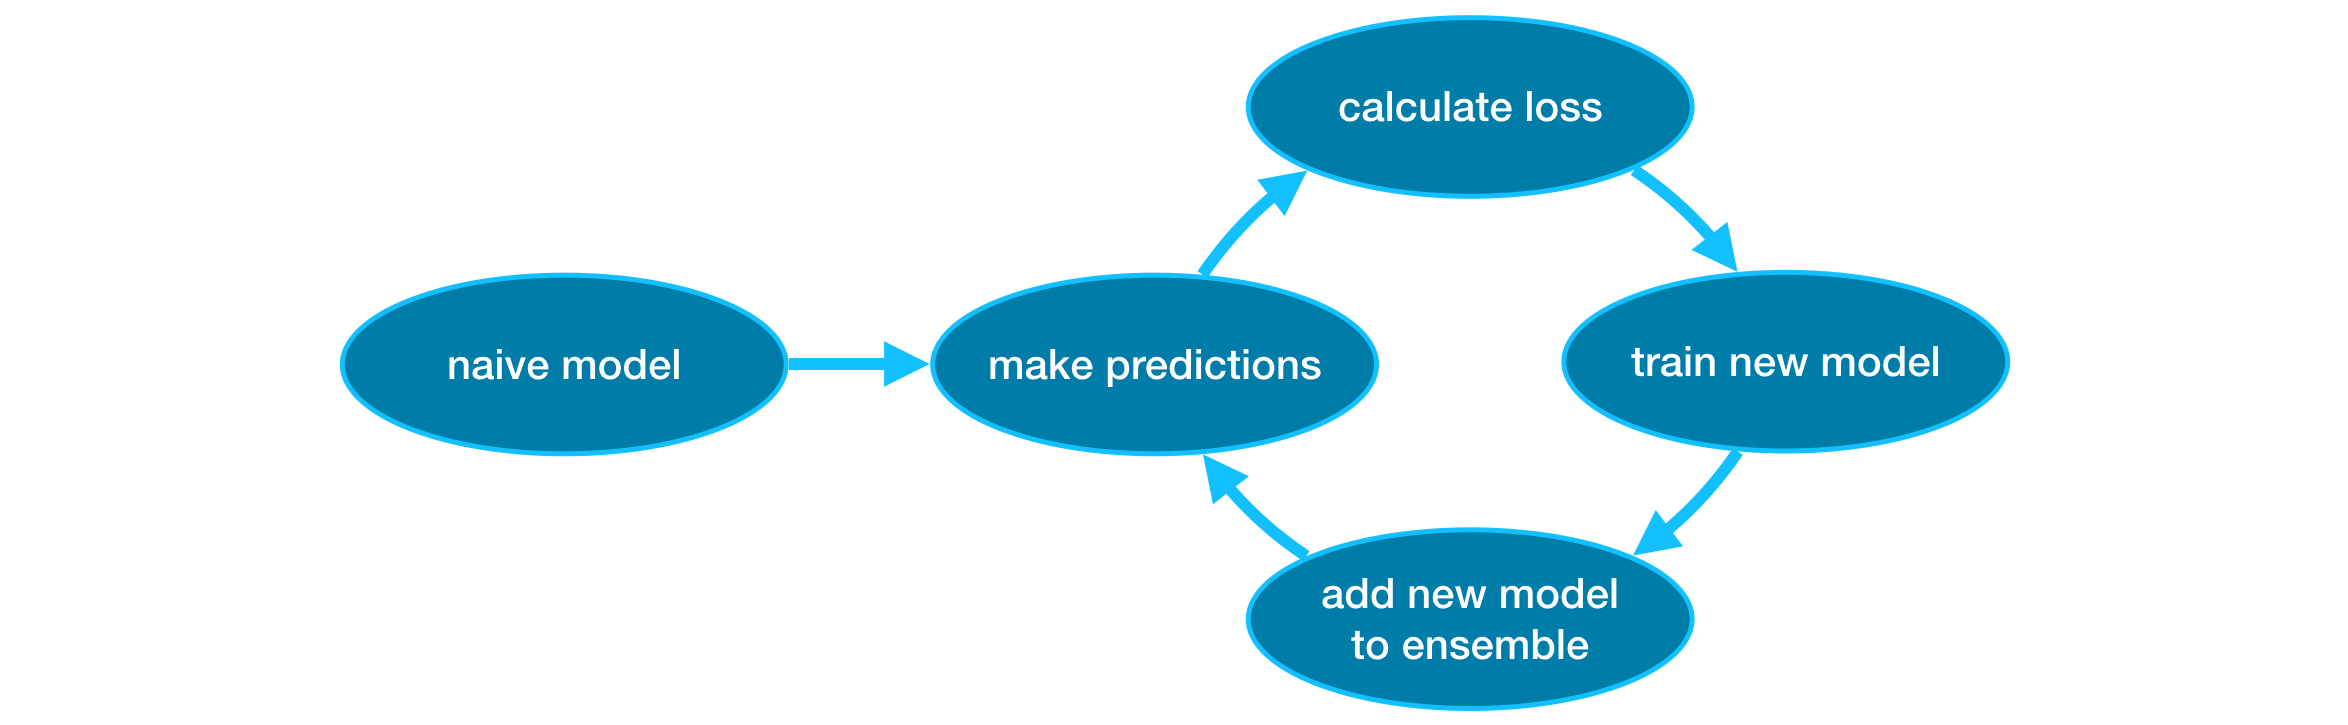

#Example
We begin by loading the training and validation data in X_train, X_valid, y_train, y_valid.

In [1]:
import pandas as pd  # Used for data processing and manipulation.
from sklearn.model_selection import train_test_split  # Splits data into training and testing sets for the model.
from xgboost import XGBRegressor  # Machine learning algorithm used for regression predictions.
from xgboost import plot_tree  # Displays the internal structure of the XGBoost model.
from sklearn.metrics import mean_absolute_error  # Tool to evaluate how accurate the model's predictions are.
import matplotlib.pyplot as plt  # Library for creating plots and visualizations.
from sklearn.model_selection import learning_curve  # Analyzes how the model's performance improves with more training data.
import numpy as np  # Library for mathematical operations and array manipulation.
import shap  # Provides insights into which features most influence the model's predictions.
from sklearn.inspection import PartialDependenceDisplay  # Displays the relationship between features and the model's output.

**Prompt:**

Write a code cell to mount Google Drive in Colab.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Prompt:**

Write a code cell to read a CSV file from Google Drive into a DataFrame.

In [3]:
from google.colab import drive
drive.mount('/content/drive')
# Menghubungkan Google Drive ke Google Colab

file_path = '/content/drive/MyDrive/melb_data.csv'
df = pd.read_csv(file_path)
# Membuka file CSV dan memuatnya ke dalam DataFrame

df.head()
# Menampilkan beberapa baris pertama dari DataFrame

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


**Prompt:**

Write a code cell to select a subset of predictors ['Rooms', 'Distance', 'Landsize', 'BuildingArea', 'YearBuilt'] and set the target variable ['Price'] from the DataFrame.

In [4]:
predictors = ['Rooms', 'Distance', 'Landsize', 'BuildingArea', 'YearBuilt']
target = 'Price'
# Defining the predictor columns and the target column

X = df[predictors]
y = df[target]
# Creating DataFrames for features (X) and target (y)

X.head(), y.head()
# Displaying the first five rows to verify the selectioN

(   Rooms  Distance  Landsize  BuildingArea  YearBuilt
 0      2       2.5     202.0           NaN        NaN
 1      2       2.5     156.0          79.0     1900.0
 2      3       2.5     134.0         150.0     1900.0
 3      3       2.5      94.0           NaN        NaN
 4      4       2.5     120.0         142.0     2014.0,
 0    1480000.0
 1    1035000.0
 2    1465000.0
 3     850000.0
 4    1600000.0
 Name: Price, dtype: float64)

**Prompt:**

Write a code cell to split the data into training and validation

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
# Splitting the dataset into training and validation sets

print(f"Training Set: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Validation Set: X_valid: {X_valid.shape}, y_valid: {y_valid.shape}")
# Displaying the dimensions of each data subset

Training Set: X_train: (10864, 5), y_train: (10864,)
Validation Set: X_valid: (2716, 5), y_valid: (2716,)


In the next code cell, we import the scikit-learn API for XGBoost (`xgboost.XGBRegressor`). As you'll see in the output, the `XGBRegressor` class has many tunable parameters.


**Prompt:**

Write a code cell to train the model using XGBoost, and print the mean absolute error on the validation set.

In [6]:
model = XGBRegressor(n_estimators=1000, learning_rate=0.05, random_state=42)
# Creating a regression model using the XGBoost algorithm

model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
# Training the model using the training data without applying early stopping

y_pred = model.predict(X_valid)
# Generating predictions based on the validation data

mae = mean_absolute_error(y_valid, y_pred)
print(f"Mean Absolute Error (MAE) on the validation set: {mae}")
# Calculating the Mean Absolute Error (MAE) on the validation data

Mean Absolute Error (MAE) on the validation set: 225972.76253566827


We also make predictions and evaluate the model.

#Parameter Tuning
XGBoost has a few parameters that can dramatically affect accuracy and training speed. The first parameters you should understand are:

`n_estimators`
Specifies how many times to go through the modeling cycle described above. It is equal to the number of models that we include in the ensemble.
* Too low a value causes underfitting, which leads to inaccurate predictions on both training data and test data.
* Too high a value causes overfitting, which causes accurate predictions on training data, but inaccurate predictions on test data (which is what we care about).

Typical values range from 100-1000, though this depends a lot on the `learning_rate` parameter discussed below.

Here is the code to set the number of models in the ensemble:

**Prompt:**

Write a code cell to create another XGBRegressor with 500 estimators, train it, and print the mean absolute error on the validation set.

In [7]:
model_500 = XGBRegressor(n_estimators=500, learning_rate=0.05, random_state=42)
# Create an XGBoost Regressor model with 500 estimators and a learning rate of 0.05

model_500.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
# Train the model using the training data and evaluate it on the validation data

y_pred_500 = model_500.predict(X_valid)
# Generate predictions on the validation data

mae_500 = mean_absolute_error(y_valid, y_pred_500)
print(f"Mean Absolute Error (MAE) on the validation set with 500 estimators: {mae_500}")
# Calculate the Mean Absolute Error (MAE) for the validation data

Mean Absolute Error (MAE) on the validation set with 500 estimators: 225931.20106544552


The MAE result of the model with n_estimators set to 500 turned out to be greater than the default value of n_estimators, which is 100.

The MAE (Mean Absolute Error) of the model with an n_estimators value of 110 turns out to be smaller than the default n_estimators value of 100, as well as n_estimators with a value of 500.

`early_stopping_rounds`
offers a way to automatically find the ideal value for `n_estimators`. Early stopping causes the model to stop iterating when the validation score stop improving, even if we aren't the hard stop for `n_estimators`. It's smart to set a high value for `n_estimators` and then use `early_stopping_rounds` to find the optimal time to stop iterating.

Since random chance sometimes causes a single round where validation scores don't improve, you need to specify a number for how many rounds of straight deterioration (keburukan) to allow before stopping. Setting `early_stopping_rounds=5` is a reasonable choice. In this case, we stop after 5 straight rounds of deteriorating validation scores.

When using `early_stopping_rounds`, you also need to set aside some data for calculating the validation scores. This is done by setting the `eval_set` parameter.

We can modify the example above to include early stopping.

---
Note:

* In the context of training machine learning models, "deteriorating" refers to a situation where the performance of the model on a validation dataset worsens over consecutive iterations during the training process. Typically, we monitor a metric (such as accuracy, mean squared error, etc.) on the validation dataset to evaluate the model's performance.

* In the given code, verbose=False is an argument passed to the fit method of the XGBRegressor model. Setting verbose to False means that during the training process, the model will not produce any output or progress messages. It will train silently without displaying information about each boosting round.

`n_jobs`

On larger datasets where runtime is a consideration, you can use parallelism to build your model faster. It's common to set the parameter `n_jobs` equal to the number of cores on your machine. On smaller datasets, this won't help.
The resulting model won't be any better, so micro-optimizing for fitting time is typically nothing but a distraction. But, it's useful in large datasets where you would otherwise spend a long time waiting during the `fit` command.

Here's the modified example.

**Prompt:**

Write a code cell to train an XGBRegressor with a custom learning rate, 90 estimators, and early stopping rounds, and print the mean absolute error on the validation set.

In [8]:
model_custom = XGBRegressor(n_estimators=90, learning_rate=0.1, random_state=42)
# Create an XGBoost Regressor model with 90 estimators and a learning rate of 0.1

# Split validation data for model evaluation
eval_set = [(X_valid, y_valid)]

model_custom.fit(X_train, y_train, eval_set=eval_set, verbose=False)
# Train the model using the training set and validate it using the validation set
# Manual early stopping can be implemented if needed

y_pred_custom = model_custom.predict(X_valid)
# Predict the validation set

mae_custom = mean_absolute_error(y_valid, y_pred_custom)
print(f"Mean Absolute Error (MAE) on the validation set with 90 estimators: {mae_custom}")
# Calculate the Mean Absolute Error (MAE) to evaluate model performance

Mean Absolute Error (MAE) on the validation set with 90 estimators: 237876.43505499815


#Feature Importance Visualization

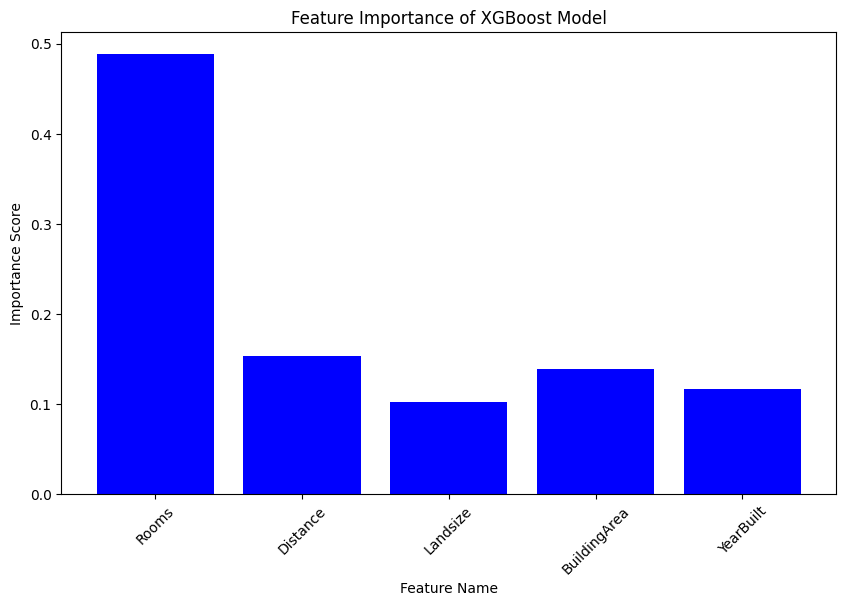

In [9]:
feature_importances = model_custom.feature_importances_
# Extract the importance value of each feature from the trained model

plt.figure(figsize=(10, 6))
plt.bar(x=np.arange(len(feature_importances)), height=feature_importances, tick_label=X.columns, color='Blue')
plt.title('Feature Importance of XGBoost Model')
plt.xlabel('Feature Name')
plt.ylabel('Importance Score')
plt.xticks(rotation=45)
plt.show()
# Display the feature importance chart from the model

Grafik feature importance menampilkan fitur-fitur yang memberikan pengaruh terbesar dalam prediksi model. Fitur dengan skor kepentingan lebih tinggi memiliki kontribusi yang lebih dominan terhadap hasil prediksi.

#Tree Structure Visualization

<Figure size 5000x2000 with 0 Axes>

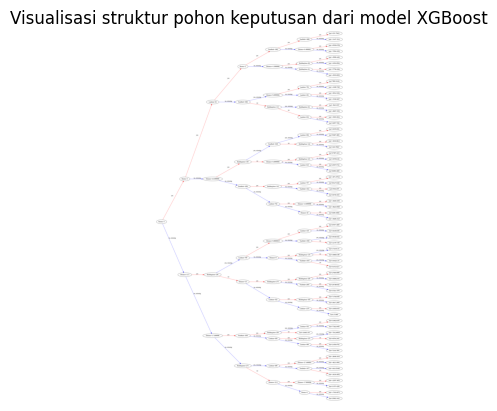

In [10]:
plt.figure(figsize=(50, 20))
plot_tree(model_custom, num_trees=0, rankdir='LR')
plt.title('Visualisasi struktur pohon keputusan dari model XGBoost')
plt.show()
# Menampilkan visualisasi struktur pohon keputusan pada model XGBoost

Struktur pohon XGBoost menggambarkan secara visual bagaimana model membuat keputusan. Setiap pohon dalam XGBoost (yang merupakan kombinasi dari beberapa pohon) menunjukkan serangkaian keputusan yang didasarkan pada fitur-fitur input.

#Learning Curve Visualization

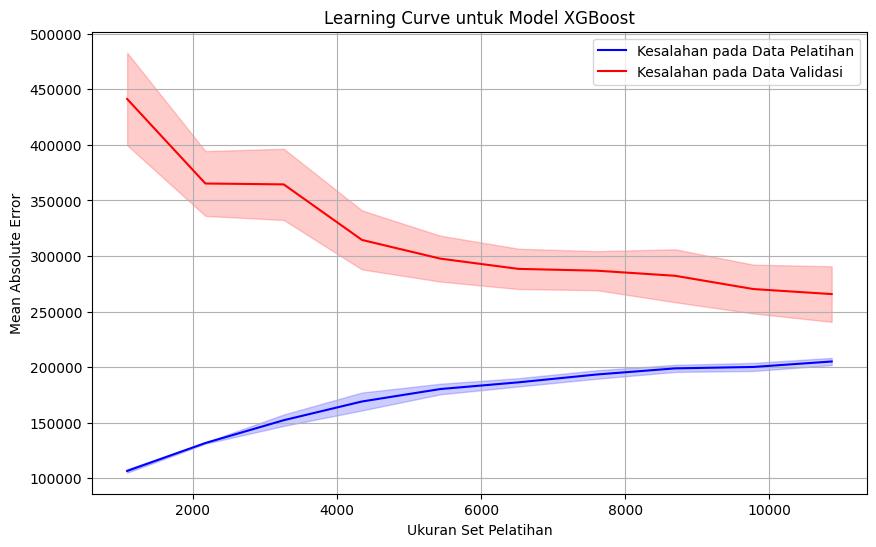

In [11]:
train_sizes, train_scores, valid_scores = learning_curve(
    XGBRegressor(n_estimators=90, learning_rate=0.1, random_state=42),  # Model XGBoost yang digunakan
    X, y,  # Fitur dan variabel target
    train_sizes=np.linspace(0.1, 1.0, 10),  # Membagi data pelatihan dalam berbagai proporsi
    cv=5,  # Menggunakan teknik 5-fold cross-validation
    scoring='neg_mean_absolute_error',  # Menggunakan Mean Absolute Error sebagai metrik evaluasi
    n_jobs=-1  # Mengoptimalkan pemrosesan dengan menggunakan semua inti CPU
)

# Menghitung rata-rata dan deviasi standar dari skor untuk data pelatihan dan validasi
train_mean = -np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = -np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

# Membuat visualisasi Learning Curve untuk model XGBoost
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Kesalahan pada Data Pelatihan', color='blue')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.plot(train_sizes, valid_mean, label='Kesalahan pada Data Validasi', color='red')
plt.fill_between(train_sizes, valid_mean - valid_std, valid_mean + valid_std, alpha=0.2, color='red')
plt.title('Learning Curve untuk Model XGBoost')
plt.xlabel('Ukuran Set Pelatihan')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid()
plt.show()


**Learning Curve** menggambarkan bagaimana performa model XGBoost berubah ketika jumlah data pelatihan bertambah.

Pada sumbu X, menunjukkan ukuran dataset pelatihan yang digunakan, sementara pada sumbu Y, menunjukkan nilai **Mean Absolute Error (MAE)**.  
Kurva **Training Error** (berwarna biru) menunjukkan tingkat kesalahan model pada data pelatihan. Kurva ini biasanya menurun seiring dengan bertambahnya data pelatihan, karena model memiliki lebih banyak informasi untuk dipelajari.  
Kurva **Validation Error** (berwarna merah) menunjukkan kesalahan model pada data validasi, yang mencerminkan seberapa baik model dapat memprediksi data yang belum pernah dilihat sebelumnya.

### Penafsiran kurva:

- **Jika Validation Error jauh lebih tinggi daripada Training Error**, ini bisa menandakan adanya **overfitting**, yang berarti model terlalu cocok dengan data pelatihan dan kesulitan dalam menggeneralisasi untuk data baru.
- **Jika Training Error dan Validation Error keduanya tinggi dan serupa**, ini menunjukkan **underfitting**, yang berarti model terlalu sederhana dan tidak mampu menangkap pola-pola penting dalam data.

#Shap Values Visualization

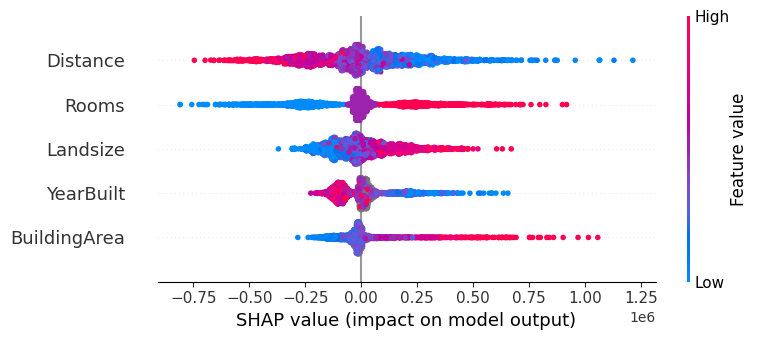

In [12]:
explainer = shap.TreeExplainer(model_custom)

shap_values = explainer.shap_values(X_valid)
# Menghitung nilai SHAP untuk dataset validasi

shap.summary_plot(shap_values, X_valid)
# Menampilkan visualisasi plot ringkasan SHAP

Plot Ringkasan SHAP memberikan gambaran mengenai kontribusi masing-masing fitur terhadap hasil prediksi model XGBoost. Pada grafik ini:

- Setiap titik mewakili nilai SHAP untuk suatu fitur pada satu data point.
- Sumbu x menunjukkan sejauh mana fitur mempengaruhi prediksi, sedangkan warna menggambarkan nilai fitur (merah untuk nilai tinggi, biru untuk nilai rendah).
- Fitur yang terletak di bagian atas grafik memiliki pengaruh terbesar terhadap prediksi secara keseluruhan.
  
Dengan grafik ini, kita dapat mengidentifikasi fitur-fitur yang paling berpengaruh pada prediksi model serta memahami bagaimana perubahan nilai fitur dapat memengaruhi hasil prediksi

#Partial Dependence Plot Visualization

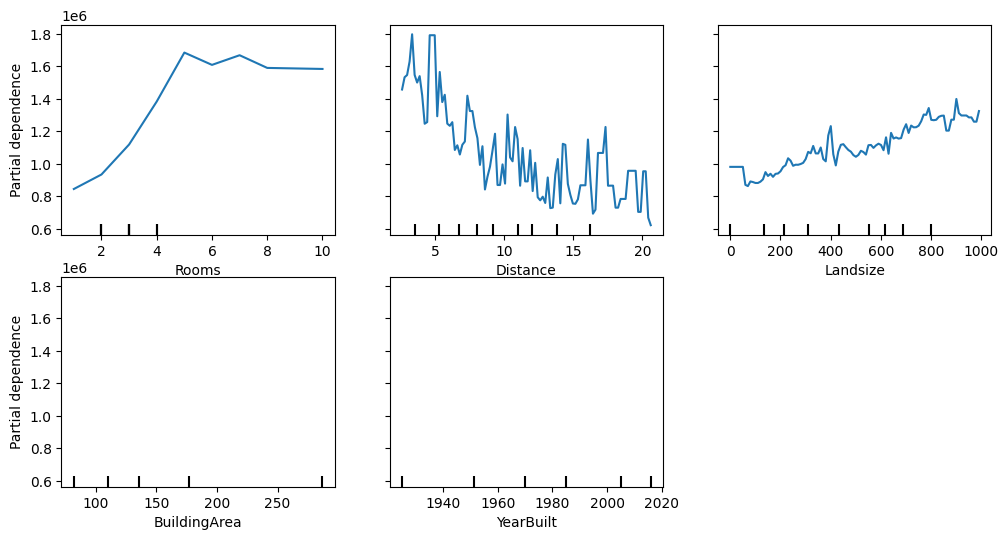

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))
PartialDependenceDisplay.from_estimator(model, X_train, features=[0, 1, 2, 3, 4], feature_names=predictors, ax=ax)  # Membuat plot ketergantungan parsial untuk semua variabel fitur
plt.title('')
plt.show()

Partial Dependence Plot (PDP) menunjukkan bagaimana perubahan rata-rata prediksi model dipengaruhi oleh variasi nilai suatu fitur, dengan asumsi fitur lainnya tetap konstan.

Sumbu x menggambarkan nilai fitur tertentu (misalnya, Rooms, Distance, Landsize, BuildingArea, YearBuilt), sementara sumbu y menunjukkan sejauh mana perubahan nilai fitur tersebut mempengaruhi prediksi rata-rata (Price). PDP berguna untuk memahami pengaruh masing-masing fitur terhadap target. Sebagai contoh, apakah peningkatan jumlah Rooms memiliki dampak signifikan terhadap prediksi harga properti, atau bagaimana jarak (Distance) memengaruhi hasil prediksi. Visualisasi ini sangat berguna dalam mengidentifikasi fitur-fitur yang memberikan kontribusi terbesar terhadap kinerja model.






